# Kernel methods for regression

Kernel-based regression combine linear regression techniques with the kernel trick.
They learn a function in the space induced by the respective kernel and the data.
For non-linear kernels, this corresponds to a non-linear function in the original space.

In this notebook, we will explore the capabilities of three of them: Suppert Vector Regression (SVR), Kernel Ridge Regression (KRR), and Gaussian Processes (GP).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm

# inline plots
%matplotlib inline

# Part 1. Kernel expansion and basis functions: Intuition

A linear regressor fits the following model to the observed data:

$$f(x) = w^\top x$$

This is the underlying function that is assumed to have generated the data, and the true data typically contains additive noise, $w^\top x + \epsilon$.

## Kernel-based function

The data model adopted by kernel-based regression techniques assumes the data fits a linear model in the feature space.
By exploiting the representer theorem kernel trick, this model can be cast back into the input space as the following "kernel expansion":

$$f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$$

Here, $\kappa(\cdot,\cdot)$ is the "kernel function", $\{x_i\}$, for $i=1,2,\dots,n$, represent the data that were used for training the model, and the coefficients $\alpha_i$ are called "expansion coefficients".

First, we will explore the the type of functions that can be modeled in this way
We will start with the Gaussian (or "[RBF](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html)") kernel:

$$\kappa(x, x_i) = \exp\left(-\gamma \Vert x - x_i \Vert^2\right)$$

The parameter $gamma$ indicates the "spikiness" of the kernel and hence allows to control the smoothness of the resulting function.

Let us plot a single basis function $\kappa(x, x_i)$ with $x_i$ fixed at the origin:

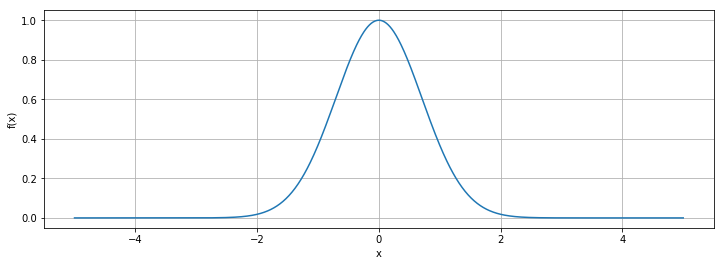

In [2]:
from sklearn.metrics.pairwise import rbf_kernel

x_i = np.array(0).reshape(-1,1)
x = np.linspace(-5,5,1000).reshape(-1,1)
gamma = 1

K = rbf_kernel(x,x_i,gamma=gamma)

plt.figure(figsize=(12,4))
plt.plot(x,K)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
#plt.show()

We now choose a different $x_i$, for instance located at $x=2$ and plot the corresponding basis function:

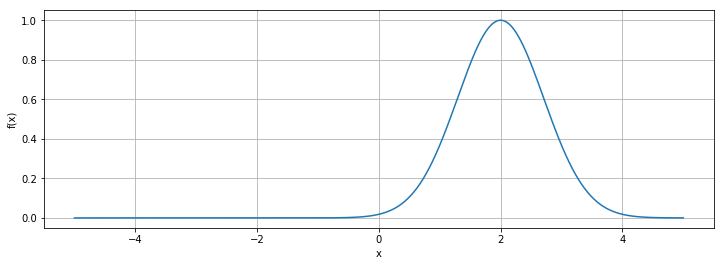

In [3]:
x_i = np.array(2).reshape(-1,1)

K = rbf_kernel(x,x_i,gamma=gamma)

plt.figure(figsize=(12,4))
plt.plot(x,K)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
#plt.show()

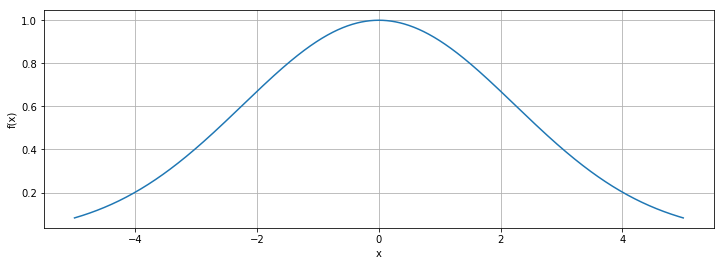

In [5]:
#::GMG::Vario gamma a la baja (es lo contraio que sigma)
x_i = np.array(0).reshape(-1,1)
K = rbf_kernel(x,x_i,gamma=0.1)

plt.figure(figsize=(12,4))
plt.plot(x,K)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)

### Kernel expansion

The complete kernel expansion $f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$ is obtained by weighing the individual basis functions with coefficients $\alpha_i$ and summing the result.
A kernel expansion with 4 "bases" $x_i$ is constructed as follows:

Dimensions of K:(1000, 4)
Dimensions of alpha_i:(4, 1)


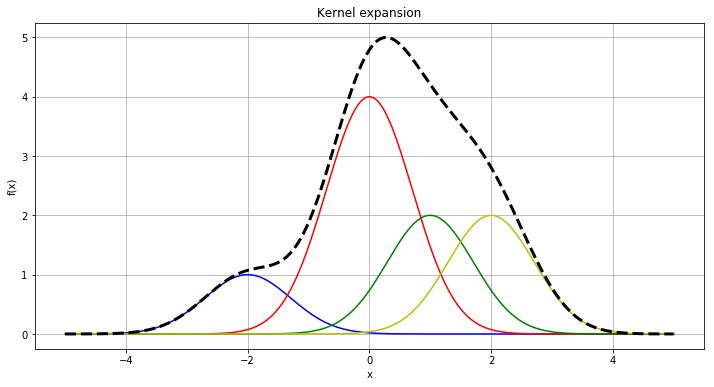

In [6]:
x_i = np.array([-2, 0, 1, 2]).reshape(-1,1)
alpha_i = np.array([1, 4, 2, 2]).reshape(-1,1)

K = rbf_kernel(x,x_i,gamma=gamma)

print("Dimensions of K:"+str(K.shape))
print("Dimensions of alpha_i:"+str(alpha_i.shape))

f = np.dot(K,alpha_i)

plt.figure(figsize=(12,6))
plt.plot(x,alpha_i[0]*K[:,0],color='b')
plt.plot(x,alpha_i[1]*K[:,1],color='r')
plt.plot(x,alpha_i[2]*K[:,2],color='g')
plt.plot(x,alpha_i[3]*K[:,3],color='y')
plt.plot(x,f,color='k',linestyle='--',linewidth=3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.title('Kernel expansion')
#plt.show()

By modifying the `gamma` parameter we obtain functions with different smoothness.

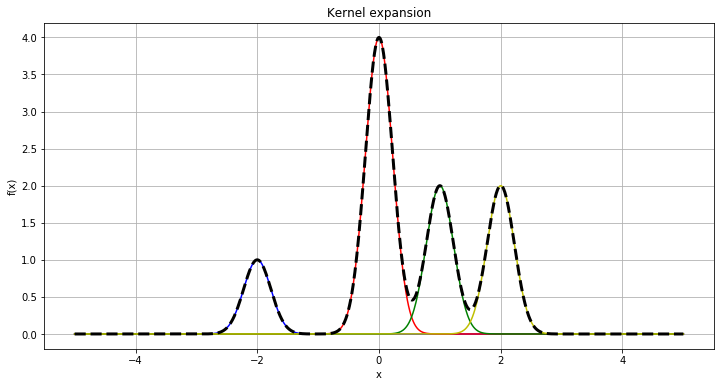

In [7]:
gamma = 10

K = rbf_kernel(x,x_i,gamma=gamma)

f = np.dot(K,alpha_i)

plt.figure(figsize=(12,6))
plt.plot(x,alpha_i[0]*K[:,0],color='b')
plt.plot(x,alpha_i[1]*K[:,1],color='r')
plt.plot(x,alpha_i[2]*K[:,2],color='g')
plt.plot(x,alpha_i[3]*K[:,3],color='y')
plt.plot(x,f,color='k',linestyle='--',linewidth=3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.title('Kernel expansion')
plt.show()

### Different kernels

In practice, kernel functions reperesent dissimilarity measures.
Apart from the standard RBF kernel many more kernels are used, such as the polynomial kernel, linear kernel, etc.
An overview of the kernels included in the `metrics` section of scikit learn can be found at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise

The Gaussian process module of scikit learn includes some advanced kernels, such as the [rational quadratic kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html), the ["white noise" kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html), etc.

An overview can be found at https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels

In the following code block we visualize one basis function of [the periodic "ExpSineSquared" kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html), which is defined as

$$\kappa(x, x_i) = \exp\left(-2 \left(\frac{\sin\left(\frac{\pi}{p} d(x, x_i)\right)}{l}\right) ^ 2\right)$$

where $l$ is the length scale ($l=1/\gamma$), $p$ is a periodicity parameter, and $d(\cdot,\cdot)$ is a distance measure (the Euclidean distance by default).

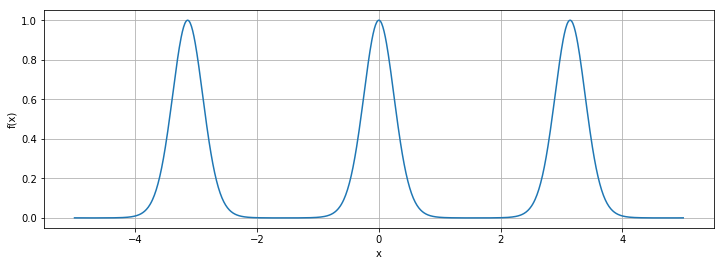

In [8]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

x_i = np.array(0).reshape(-1,1)
x = np.linspace(-5,5,1000).reshape(-1,1)

length_scale = .5
periodicity = np.pi
kernel = ExpSineSquared(length_scale=length_scale,periodicity=periodicity )

K = kernel.__call__(x,x_i)

plt.figure(figsize=(12,4))
plt.plot(x,K)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
#plt.show()

### Combinations of kernels

Kernel functions can be combined in several ways to produce more complex basis functions.
For instance, the summation or multiplication of two kernel functions produces a new kernel function.

Exercise 1: Combinations of kernels
---

Kernel functions can be combined in several ways to produce new kernel functions.
For instance, the summation or multiplication of two kernel functions produces a new kernel function.

1. Write a function to calculate a kernel that is the multiplication of the `ExpSineSquared` kernel and a kernel of your choice (RBF, linear, poly, etc.).
2. Calculate and plot the kernel expansion $f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$:
    1. Choose 4 or 5 one-dimensional "bases" $x_i$.
    2. Generate the corresponding coefficients $\alpha_i$ randomly (with a fixed random seed).
    3. Calculate and plot the kernel expansion $f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$ for a range of x values that includes at least the bases.
    4. [Optional] Plot the individual basis functions corresponding to each base.


In [ ]:
# 1. Kernel function
def my_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, K(x1_i,x2_j) in position i,j
    """
    
    # to be completed
    K = rbf_kernel(x,x_i,gamma=gamma) * 
    
    return K

In [ ]:
# 2. Kernel expansion

# Part 2. Regression with SVR and KRR

Kernel methods for regression apply linear regression techniques in the feature space. We will first run a simple linear regression experiment on 1D data generated from a linear model.

## Data generation, linear model

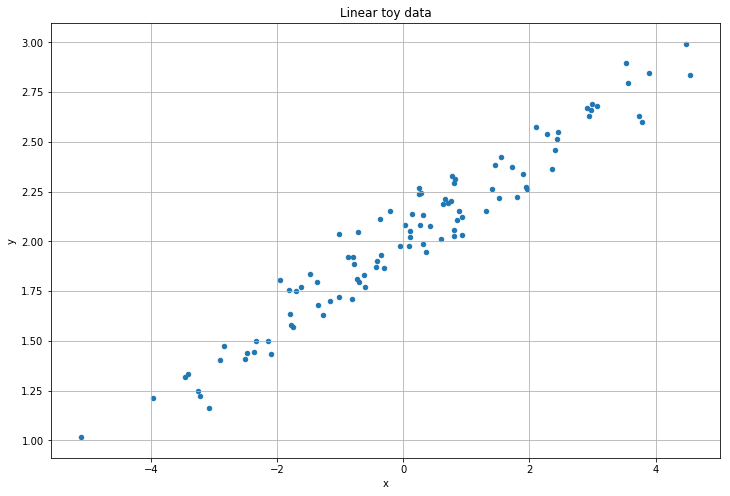

In [13]:
# fix random seed
np.random.seed(seed=0)

# generate toy data
n_data = 100
w = 0.2
b = 2
X = np.random.normal(0,2,n_data)
noise = np.random.normal(0,0.1,n_data)
y = w*X + b + noise

plt.figure(figsize=(12,8))
plt.scatter(X,y,s=20)
plt.title('Linear toy data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.show()

In [10]:
# Save data for later use
linear_data = {'X': X.reshape(-1, 1), 'y': y.reshape(-1, 1)}

In [11]:
X.shape

(100,)

In [17]:
X.reshape(-1,1).shape

(100, 1)

In [12]:
y.shape

(100,)

In [18]:
y.reshape(-1, 1).shape

(100, 1)

## Linear estimator

We now run the linear least squares estimator with l2-norm regularization, from the [`linear_model.LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) module, and we plot the data and the regression solution.

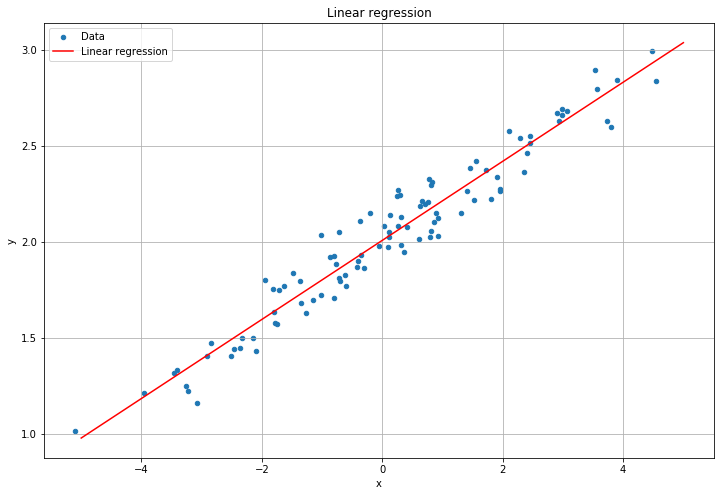

In [19]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(linear_data['X'], linear_data['y'])

# Test the regressor
X_test = np.linspace(-5,5,100).reshape(-1,1)
y_pred = regr.predict(X_test)

plt.figure(figsize=(12,8))
h_data = plt.scatter(linear_data['X'],linear_data['y'],s=20,label='Data')
h_line, = plt.plot(X_test,y_pred,color='r',label='Linear regression')
plt.title('Linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend(handles=[h_data, h_line])
#plt.show()

Clearly, in this case we obtain an excellent fit. The (hyper)plane learned by the estimator corresponds to the linear model $f(x) = w^\top x + b$.

## Nonlinear model (toy data)

Next, we generate some data according to a nonlinear 1D model, in this case the `sinc` function.

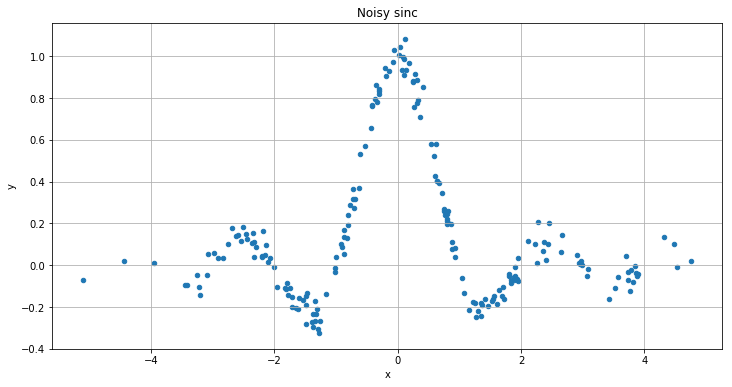

In [20]:
# fix random seed
np.random.seed(seed=0)

n_data = 200
X = np.random.normal(0,2,n_data)
noise = np.random.normal(0,0.05,n_data)
y = np.sinc(X) + noise

plt.figure(figsize=(12,6))
plt.scatter(X,y,s=20)
plt.title('Noisy sinc')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.show()

In [21]:
# Save data for later use
sinc_data = {'X': X.reshape(-1, 1), 'y': y.reshape(-1, 1)}

Let us try to fit the linear model $f(x) = w^\top x + b$ to these data.

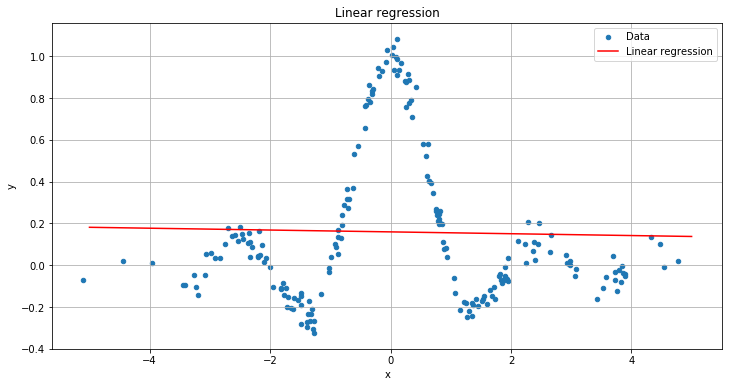

In [22]:
#from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(sinc_data['X'], sinc_data['y'])

# Test the regressor
X_test = np.linspace(-5,5,100).reshape(-1,1)
y_pred = regr.predict(X_test)

plt.figure(figsize=(12,6))
h_data = plt.scatter(sinc_data['X'],sinc_data['y'],s=20,label='Data')
h_line, = plt.plot(X_test,y_pred,color='r',label='Linear regression')
plt.title('Linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend(handles=[h_data, h_line])
#plt.show()

As expected, the solution of the linear regression does not capture any of the structure in the data apart from, most probably, the data mean.

## Linear regression on a local subset

We could, however, estimate a linear model on a local subset of the data. The next code snippet selects the data that lie in $x \in[0,1]$ and performs linear regression on these data.

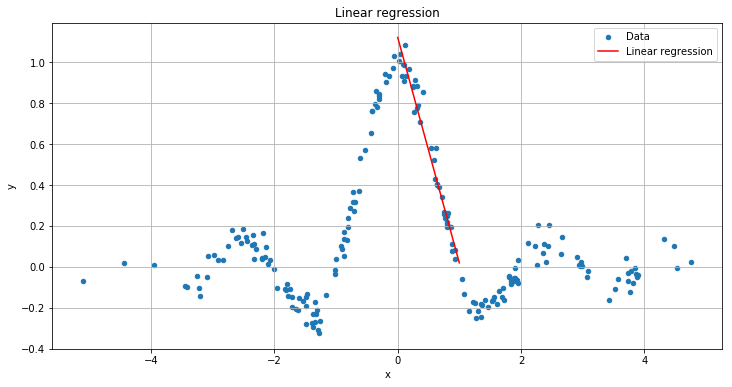

In [23]:
# select data between x=0 and x=1

idx = np.logical_and(sinc_data['X'] >= 0, sinc_data['X'] <= 1)

X = sinc_data['X'][idx].reshape(-1,1)
y = sinc_data['y'][idx].reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X,y)

# Test the regressor
X_test = np.linspace(0,1,100).reshape(-1,1)
y_pred = regr.predict(X_test)

plt.figure(figsize=(12,6))
h_data = plt.scatter(sinc_data['X'],sinc_data['y'],s=20,label='Data')
h_line, = plt.plot(X_test,y_pred,color='r',label='Linear regression')
plt.title('Linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend(handles=[h_data, h_line])
#plt.show()

If the data shows nonlinear structure, a linear regressor may be useful at most to model the data at a local level. Instead of exploring this idea (which could be exploited to construct "piecewise linear" regression), we will focus on introducing kernel functions in the data model.

## Nonlinear regression with SVR and KRR

We will now perform nonlinear regression using the [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) and [KRR](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) algorithms.
As we've seen, these algorithms aim to find suitable coefficients $\alpha_i$ for the model $f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$ by minimizing the prediction error according to a given criterion (L2-norm, L1-norm, $\epsilon$-insensitive,...).

First, we apply both algorithms on the noisy sinc data, using some fixed choice for the hyperparameters.

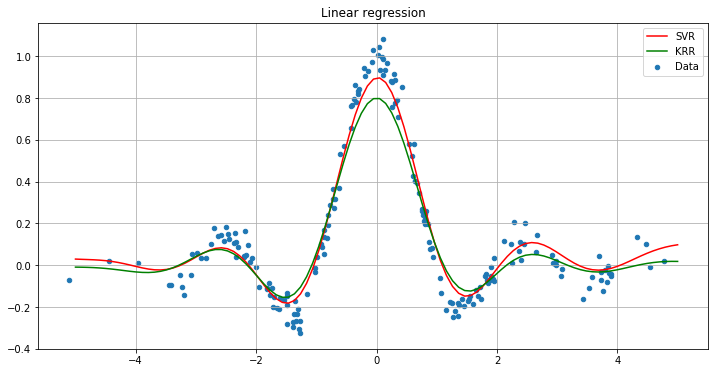

In [24]:
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

# train the SVR. gamma ~ 1/lengthscale
clf_svr = SVR(kernel='rbf', C=.1, gamma=1)
clf_svr.fit(sinc_data['X'], sinc_data['y'].ravel())

# train the KRR
clf_krr = KernelRidge(kernel='rbf', alpha=5, gamma=1)
clf_krr.fit(sinc_data['X'], sinc_data['y'])

# Test the regressors
X_test = np.linspace(-5,5,100).reshape(-1,1)
y_pred_svr = clf_svr.predict(X_test)
y_pred_krr = clf_krr.predict(X_test)

plt.figure(figsize=(12,6))
plt.scatter(sinc_data['X'],sinc_data['y'],s=20,label='Data')
plt.plot(X_test,y_pred_svr,color='r',label='SVR')
plt.plot(X_test,y_pred_krr,color='g',label='KRR')
plt.title('Linear regression')
plt.grid(True)
plt.legend()
plt.show()

Let us have a look at the support vectors found and their coefficients:

In [25]:
print("Indices of support vectors:")
print(clf_svr.support_)
print(clf_svr.support_.shape)

Indices of support vectors:
[  8  10  14  18  20  21  26  28  35  36  46  48  54  58  60  72  79  82
  87  92  96 100 101 124 128 131 134 136 137 139 143 151 163 177 179 182
 185 198]
(38,)


In [26]:
print("Coefficients:")
print(clf_svr.dual_coef_)

Coefficients:
[[ 0.1         0.1        -0.1         0.1        -0.06595214 -0.03146126
   0.1        -0.00422967  0.04438896  0.06066107  0.1        -0.1
   0.1        -0.1        -0.1         0.1         0.1        -0.08245623
   0.1         0.1         0.1        -0.07793937  0.02982496 -0.0066417
  -0.1        -0.1        -0.1        -0.1         0.00137131  0.1
  -0.1        -0.1         0.1        -0.1         0.1        -0.1
  -0.1         0.03243408]]


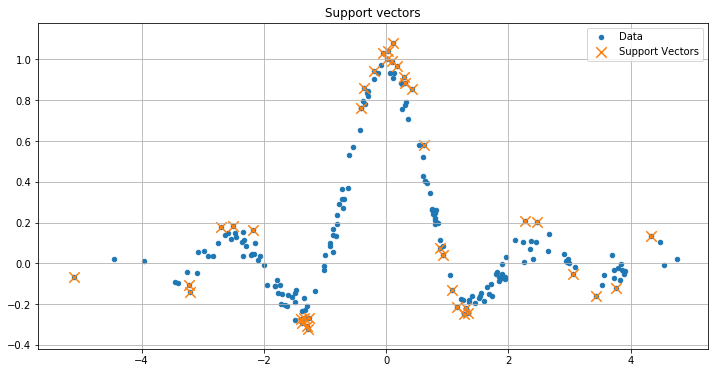

In [27]:
# plot of the support vectors
#::note::there are many support vectors, we can reduce them by changing a hyperparameter
#        C in SVR i.e .1 --> 1
plt.figure(figsize=(12,6)) 
plt.scatter(sinc_data['X'],sinc_data['y'],s=20,label='Data')
plt.scatter(sinc_data['X'][clf_svr.support_],sinc_data['y'][clf_svr.support_],\
            s=110,marker='x',label='Support Vectors')
plt.title('Support vectors')
plt.grid(True)
plt.legend()
#plt.show()

Indices of support vectors:
[ 20  37  64  71  72  79  87  92 101 127 134 136 139 151 185 188]
(16,)


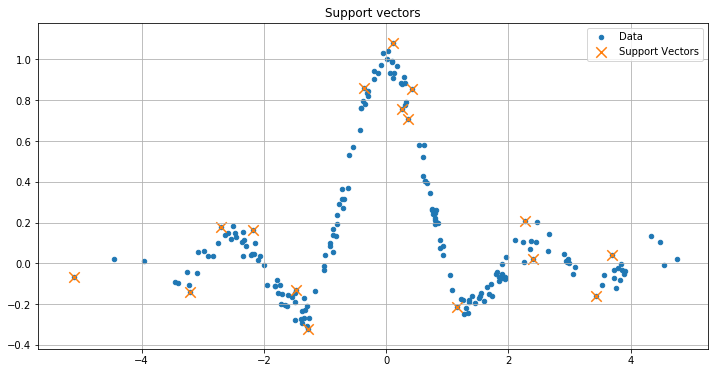

In [30]:
#::note::there are many support vectors, we can reduce them by changing a hyperparameter
#        C in SVR i.e .1 --> 1
clf_svr = SVR(kernel='rbf', C=1, gamma=1)
clf_svr.fit(sinc_data['X'], sinc_data['y'].ravel())
print("Indices of support vectors:")
print(clf_svr.support_)
print(clf_svr.support_.shape)
plt.figure(figsize=(12,6)) 
plt.scatter(sinc_data['X'],sinc_data['y'],s=20,label='Data')
plt.scatter(sinc_data['X'][clf_svr.support_],sinc_data['y'][clf_svr.support_],\
            s=110,marker='x',label='Support Vectors')
plt.title('Support vectors')
plt.grid(True)
plt.legend()

## Parameter optimization by Grid Search and Cross-validation

Instead of fixing the parameters, we can apply the [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to perform a grid search of candidate parameters and select the best set using cross-validation.

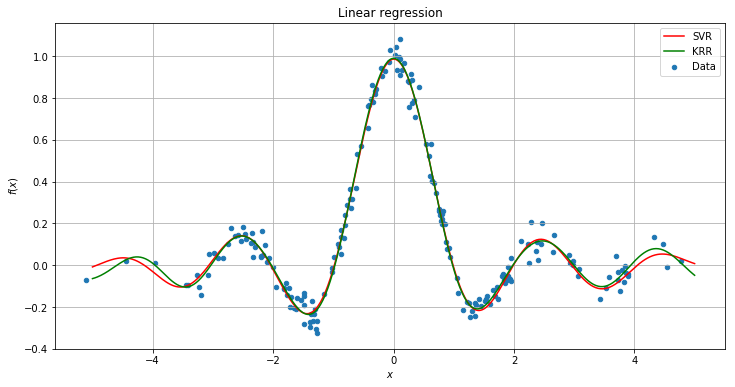

In [31]:
from sklearn.model_selection import GridSearchCV

clf_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.5), cv=5,
                   param_grid={"C": [1e-1, 1e0, 1e1, 1e2],
                               "epsilon": [0.05, 0.1, 0.5],
                               "gamma": np.logspace(-2, 2, 5)})

clf_krr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.5), cv=5,
                  param_grid={"alpha": [1e-1, 1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

# train classifiers
clf_svr.fit(sinc_data['X'], sinc_data['y'].ravel())
clf_krr.fit(sinc_data['X'], sinc_data['y'])

# Test the regressors
X_test = np.linspace(-5,5,500).reshape(-1,1)
y_pred_svr = clf_svr.predict(X_test)
y_pred_krr = clf_krr.predict(X_test)

plt.figure(figsize=(12,6))
plt.scatter(sinc_data['X'],sinc_data['y'],s=20,label='Data')
plt.plot(X_test,y_pred_svr,color='r',label='SVR')
plt.plot(X_test,y_pred_krr,color='g',label='KRR')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid(True)
plt.legend()
#plt.show()

In [32]:
print('Best parameters for SVR: '+ str(clf_svr.best_params_))
print('Best parameters for KRR: '+ str(clf_krr.best_params_))

Best parameters for SVR: {'C': 1.0, 'epsilon': 0.05, 'gamma': 1.0}
Best parameters for KRR: {'alpha': 0.01, 'gamma': 1.0}


In [33]:
print(clf_svr.best_estimator_)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=1.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Exercise 2: Motorcycle Data
---

Exercise: Train both regression techniques (SVR and KRR) on the motorcycle data set. Determine the best hyperparameters by running the GridSearchCV optimization technique.

1. Learn the optimal hyperparameters.
2. Produce predictions and plot.

In [ ]:
#::GMG::Estimar la función de times/accel
#       con SVR y KRR con greadSearchCV
#       
df = pd.read_csv('data/motor.csv',delimiter=';')

print(df.head())

   times  accel  strata    v
0    2.4    0.0       1  3.7
1    2.6   -1.3       1  3.7
2    3.2   -2.7       1  3.7
3    3.6    0.0       1  3.7
4    4.0   -2.7       1  3.7


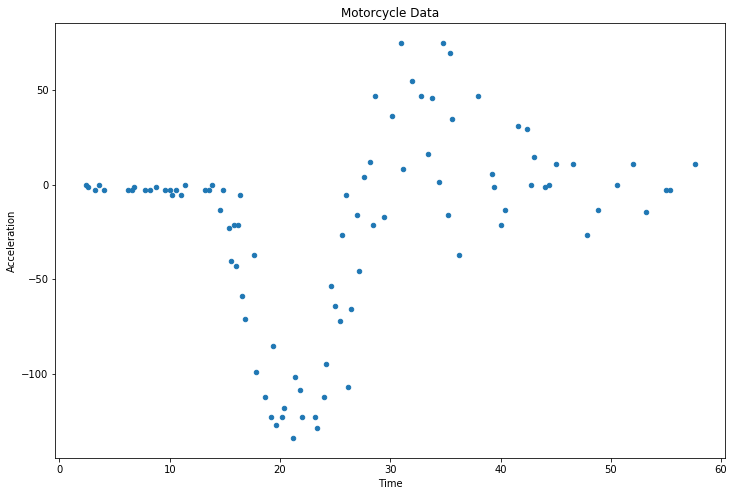

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(df.times,df.accel,s=20)
plt.title('Motorcycle Data')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()

In [25]:
#::CLASE::
# 1. Learn the optimal hyperparameters
# 2. Plot

# Part 3. Gaussian Process Regression

Gaussian Process Regression (GPR) is a Bayesian kernel-based technique that allows to perform nonlinear regression and thus to characterize nonlinear relationships between variables.
When producing predictions for a new input, GPR outputs the complete probability distribution of the estimated output, which is a Gaussian centered around the "prediction mean".
Interestingly, the prediction mean of KRR and GPR are identical. The "prediction variance" calculated by GPR yields an uncertainty interval for each prediction.

A Gaussian process is an immediate generalization of the multivariate normal to infinite dimensions.
It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution.
Thus, the marginalization property is explicit in its definition.
Another way of thinking about an infinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an infinite vector that only returns values (indexed by the inputs) when the function is called upon to do so.
By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

Gaussian processes are Bayesian techniques: After specifying a model for the data, a prior on the functional form is chosen. Then, the data is observed.
Finally, the posterior distribution of the function to estimate is calculated using Bayes' rule.

### Selecting a prior

The prior of a Gaussian process is encoded in the kernel function, which represents the covariance between any two output points. Below we select a Gaussian (RBF) prior with length scale 1, and we draw several functions that correspond to this covariance.

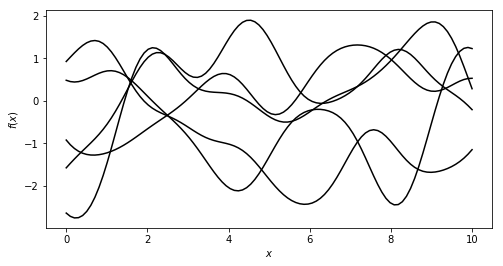

In [34]:
from sklearn.gaussian_process.kernels import RBF

# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)

mu = np.zeros(len(x))

length_scale = 1
kernel = RBF(length_scale)
K = kernel.__call__(x.reshape(-1,1),x.reshape(-1,1))

draws = np.random.multivariate_normal(mu, K, 5)

# plot a selection of unconstrained functions
fig = plt.figure(figsize=(8, 4))
plt.plot(x, draws.T, '-k')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

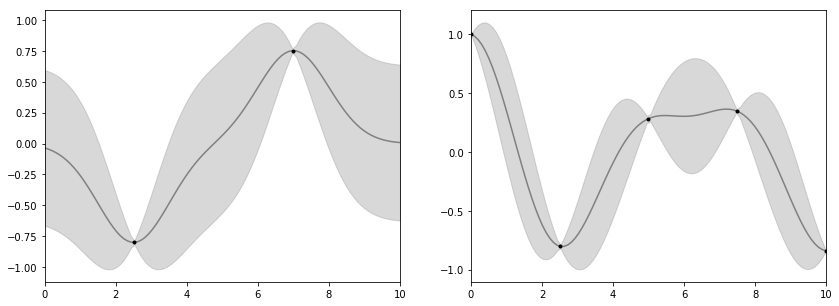

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C

# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)

gp_kernel = C(0.1) * RBF(1)

# switch off the optimizer option for this example
gp1 = GaussianProcessRegressor(kernel=gp_kernel,optimizer=None)
gp1.fit(x1[:, None], y1)
f1, sigma1 = gp1.predict(x[:, None], return_std=True)

# Constrain the mean and covariance with more points
x2 = np.linspace(0,10,5).T
y2 = np.cos(x2)

gp2 = GaussianProcessRegressor(kernel=gp_kernel,optimizer=None)
gp2.fit(x2[:, None], y2)
f2, sigma2 = gp2.predict(x[:, None], return_std=True)

# plot
fig = plt.figure(figsize=(14, 5))

# plot a constrained function
# Las bandas grises contienen el 95% de las funciones más probable que xplican los dos puntos
# con el prior que hemos elegido y en negro de la más probable del conjunto
ax = fig.add_subplot(121)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * sigma1, f1 + 2 * sigma1, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)

# plot another constrained function
# ahora nos llegan dos puntos más  y ahora las bandas de incertidumbre son más estrechas
# lo cual quiere decir que se han restringido las posibles funciones 
#::nota::se empieza con un conjunto infinito de funciones que se van restringiendo a medida
#        que se aportan datos
# resulta que KRR (Kernel Ridge Regression) coincide con la más probable que nos da GPR
ax = fig.add_subplot(122)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * sigma2, f2 + 2 * sigma2, color='gray', alpha=0.3)
ax.plot(x2, y2, '.k', ms=6)

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

## GPR on noisy sinc data

At this point it is interesting to note that we have not considered any noise in the model.
In the implementation of GPR in scikit-learn, Gaussian noise is added by adding a Gaussian component to the kernel: `kernel = RBF() + WhiteKernel()`.

In the following example we will apply GPR to the noisy sinc data.
We could search for the optimal hyperparameters by running the `GridSearchCV` utility, but GPR includes a more powerful tool.
In particular, the hyperparameters of the kernel are optimized during fitting of `GaussianProcessRegressor` by maximizing the log-marginal-likelihood (LML) based on the passed optimizer.
As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer.
The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, `None` can be passed as optimizer.

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Instanciate a Gaussian Process model
# whitekernel es ruido blanco (Ppara modelarlo)
# n_restarts_optimizer para buscar los hiperparámetros internos del GBR
# la constante es un kernel constante (es una forma de darle amplitud al kernel gaussiano)
# C(empieza en, rango de búsqueda), RBF (empeza en, rango), whitekernel (empieza en, rango)
# aquí no se usa gamma, sino 10 que es la "suavidad"
gp_kernel = C(1.0, (1e-2, 1e+2)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(0.1,(1e-2,1e2))
gp = GaussianProcessRegressor(kernel=gp_kernel,
                              n_restarts_optimizer=10)

# Fit to data using (Log)(Marginal) Maximum Likelihood Estimation of the parameters
gp.fit(sinc_data['X'], sinc_data['y'])

print("GPML kernel: %s" % gp.kernel_)
# esto es un máximo, si encontramos otro mejor, más grande es
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 0.382**2 * RBF(length_scale=0.803) + WhiteKernel(noise_level=0.01)
Log-marginal-likelihood: 218.517


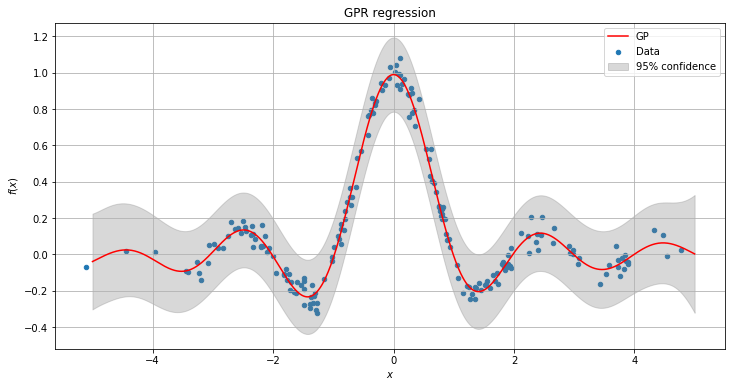

In [37]:
# Make the prediction on the meshed x-axis
# ahora tenemos zonas uncertidumbre y el coste computacional es similar que KRR
# fuera del rango de los datos la banda es la del prior
# solo donde hay datos reducimos las incertidumbre
X_test = np.linspace(-5,5,1000).reshape(-1,1)
#X_test = np.linspace(-10,10,1000).reshape(-1,1)

y_pred, sigma = gp.predict(X_test, return_std=True)

plt.figure(figsize=(12,6))
plt.scatter(sinc_data['X'],sinc_data['y'],s=20,label='Data')
plt.plot(X_test,y_pred,color='r',label='GP')
plt.fill_between(X_test.ravel(), y_pred.ravel() - 2 * sigma, y_pred.ravel() + 2 * sigma,
                 color='gray', alpha=0.3,label='95% confidence')
plt.title('GPR regression')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid(True)
plt.legend()
plt.show()

## GP regression on the linear data

In [38]:
# Instanciate a Gaussian Process model
gp_kernel = C(1.0, (1e-2, 1e+2)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(0.1,(1e-2,1e2))
gp = GaussianProcessRegressor(kernel=gp_kernel,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(linear_data['X'], linear_data['y'])

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 3.6**2 * RBF(length_scale=27.1) + WhiteKernel(noise_level=0.0108)
Log-marginal-likelihood: 74.793


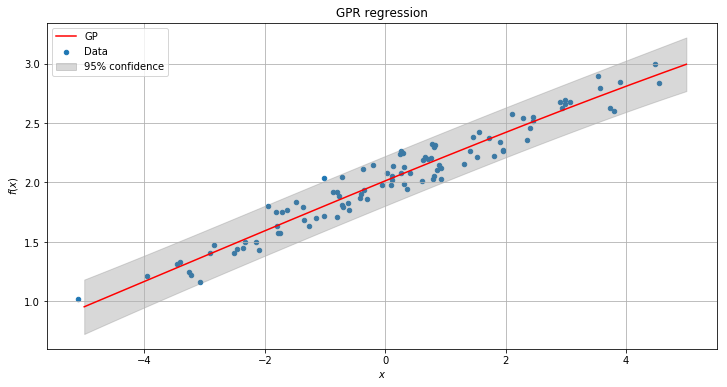

In [39]:
#lengh-scale es la "suavidad"
X_test = np.linspace(-5,5,1000).reshape(-1,1)
#X_test = np.linspace(-10,10,1000).reshape(-1,1)

# Make the prediction on the meshed x-axis
y_pred, sigma = gp.predict(X_test, return_std=True)

plt.figure(figsize=(12,6))
plt.scatter(linear_data['X'],linear_data['y'],s=20,label='Data')
plt.plot(X_test,y_pred,color='r',label='GP')
plt.fill_between(X_test.ravel(), y_pred.ravel() - 2 * sigma, y_pred.ravel() + 2 * sigma,
                 color='gray', alpha=0.3,label='95% confidence')
plt.title('GPR regression')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid(True)
plt.legend()
plt.show()

## Time series prediction with Gaussian Process regression

This example is based on Section 5.4.3 of “Gaussian Processes for Machine Learning” [RW2006].
It illustrates an example of complex kernel engineering and hyperparameter optimization using gradient ascent on the log-marginal-likelihood.
The data consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 1997.
The objective is to model the CO2 concentration as a function of the time t.

The kernel is composed of several terms that are responsible for explaining
different properties of the signal:

- a long term, smooth rising trend is to be explained by an RBF kernel. The
  RBF kernel with a large length-scale enforces this component to be smooth;
  it is not enforced that the trend is rising which leaves this choice to the
  GP. The specific length-scale and the amplitude are free hyperparameters.

- a seasonal component, which is to be explained by the periodic
  ExpSineSquared kernel with a fixed periodicity of 1 year. The length-scale
  of this periodic component, controlling its smoothness, is a free parameter.
  In order to allow decaying away from exact periodicity, the product with an
  RBF kernel is taken. The length-scale of this RBF component controls the
  decay time and is a further free parameter.

- smaller, medium term irregularities are to be explained by a
  RationalQuadratic kernel component, whose length-scale and alpha parameter,
  which determines the diffuseness of the length-scales, are to be determined.
  According to [RW2006], these irregularities can better be explained by
  a RationalQuadratic than an RBF kernel component, probably because it can
  accommodate several length-scales.

- a "noise" term, consisting of an RBF kernel contribution, which shall
  explain the correlated noise components such as local weather phenomena,
  and a WhiteKernel contribution for the white noise. The relative amplitudes
  and the RBF's length scale are further free parameters.

Maximizing the log-marginal-likelihood after subtracting the target's mean
yields the following kernel with an LML of -83.214::

````
    34.4**2 * RBF(length_scale=41.8)
    + 3.27**2 * RBF(length_scale=180) * ExpSineSquared(length_scale=1.44,periodicity=1)
    + 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957)
    + 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)
````

**::GMG::** cada término tiene su justificación

Thus, most of the target signal (34.4ppm) is explained by a long-term rising
trend (length-scale 41.8 years). The periodic component has an amplitude of
3.27ppm, a decay time of 180 years and a length-scale of 1.44. The long decay
time indicates that we have a locally very close to periodic seasonal
component. The correlated noise has an amplitude of 0.197ppm with a length
scale of 0.138 years and a white-noise contribution of 0.197ppm. Thus, the
overall noise level is very small, indicating that the data can be very well
explained by the model. The figure shows also that the model makes very
confident predictions until around 2015.

First, we will visualize the data:

**::GMG::** Aquí hay un problema de descarga de los datos. ¿Opciones?

**::NOTA::** El ejemplo [está en sckit-learn](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html). La página original de los datos supongo que [es del NOAA](https://www.esrl.noaa.gov/gmd/ccgg/trends/). He visto más posibles fuenetes: [1](http://www.statsmodels.org/stable/datasets/generated/co2.html), [2](https://cdiac.ess-dive.lbl.gov/trends/co2/sio-keel-flask/sio-keel-flaskmlo_c.html), y [en openml](https://www.openml.org/d/41187), pero `fecth_openml` no estña en la versión de sckit-learn que se está usando. Tal vez [se podría usar su biblioteca](https://openml.github.io/openml-python/master/examples/flows_and_runs_tutorial.html).

In [ ]:
#from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_mldata

def load_mauna_loa_atmospheric_co2():
    #ml_data = fetch_openml(data_id=41187, cache=False)
    ml_data = fetch_mldata('mauna-loa-atmospheric-co2').data
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    #months = np.asarray(months).reshape(-1, 1)
    #avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

X, y = load_mauna_loa_atmospheric_co2()

# Illustration
fig = plt.figure(figsize=(15,8))
plt.scatter(X, y, c='k')
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

We will now apply Gaussian Process regression using the kernel given in the GPML book:

In [ ]:
from sklearn.gaussian_process.kernels import RationalQuadratic

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

The GP regressor obtains a log-marginal-likelihood of $-117.023$ on these data, with the predefined kernel function.

Let us have a look at the predictions made using this regressor:

In [ ]:
X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

In the final part of this example, we will let the optimizer finetune the hyperparameters of the kernel function:

In [ ]:
# Kernel with generic parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

# Fit the Gaussian Process regressor, and optimize the hyperparameters
gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

If all went correctly, we should obtain a higher log-marginal-likelihood on these data after optimizing the kernel function hyperparameters.
This solution should fit slightly better to the data, as the optimizer aims to maximize the LML.

Let us have a look at the predictions made using this regressor:

In [ ]:
# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()